In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams as rc
from matplotlib.colors import LogNorm, SymLogNorm
import os
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
# import seaborn as sn

rc['font.size']=16
rc['axes.titlesize']=16
rc['text.usetex']=True

analyze_traj_Chr10_T200.0_F0.0_Ta1.0_Esoft0.0_R050.0_G2712_blocksize100_kb10.0_dt0.001_rep1_HiC.npy
0.9998766054241213 0.05337365309921404
analyze_traj_Chr10_T200.0_F2.0_Ta10.0_Esoft0.0_R050.0_G2712_blocksize100_kb10.0_dt0.001_rep1_HiC.npy
0.9998766054241213 0.05734371043362295


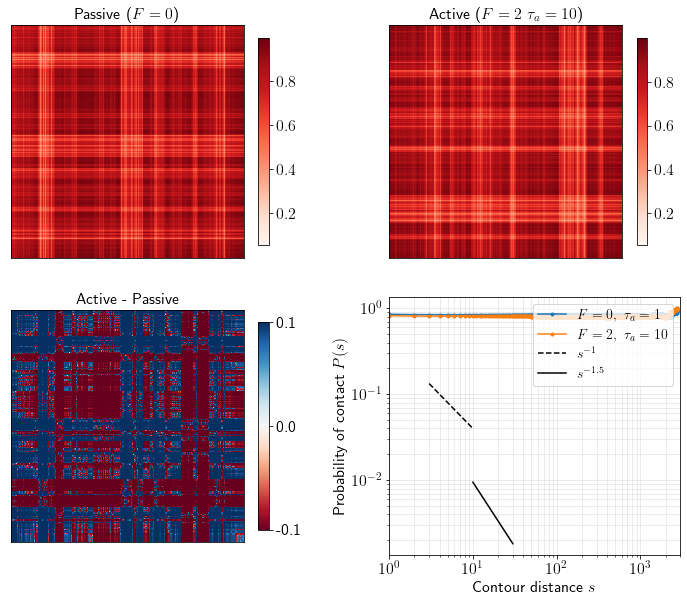

In [11]:
fig,[ax, [ax3,ax4]]=plt.subplots(2,2, figsize=(12,10), gridspec_kw={'wspace':0.3, 'hspace':0.1})

Ta=100.
F=0.5
fpath='../../data_new/Chr10/hic/'

hic=[np.zeros(shape=(2712,2712)),np.zeros(shape=(2712,2712))]

for mm, (Ta, F) in enumerate(zip([1,10],[0, 2])):
    for fname in os.listdir(fpath):
        # print(fname)
        if 'Ta{:.1f}'.format(Ta) in fname and 'F{:.1f}'.format(F) in fname:
            print(fname)
            hic[mm]+=np.load(fpath+fname)
    
    #load hic        
    hic[mm]=hic[mm]
    print(hic[mm].max(),hic[mm].min())
    #plot hic
    c=ax[mm].imshow(hic[mm], cmap='Reds')#,norm=LogNorm(vmin=1e-1, vmax=1))
    plt.colorbar(c,ax=ax[mm],shrink=0.8)
    ax[mm].set_xticks([])
    ax[mm].set_yticks([])
    if F==0: ax[mm].set_title('Passive ($F = {}$)'.format(F))
    else: ax[mm].set_title('Active ($F = {}\ \\tau_a = {:.0f}$)'.format(F,Ta))
    
    #plot Ps
    dist=[]
    for j in range(1,hic[mm].shape[0]):
        dist.append(np.mean(np.diag(hic[mm],k=j)))
    maxD=np.max(dist)
    dist=np.array(dist)/maxD
    ax4.loglog(dist,'.-', label='$F = {},\ \\tau_a = {:.0f}$'.format(F,Ta),)



c=ax3.imshow(hic[1]-hic[0], cmap='RdBu',norm=SymLogNorm(vmin=-0.1, vmax=0.1, linthresh=1e-5))
plt.colorbar(c,ax=ax3,ticks=[0.1,0,-0.1], format='%.1f', shrink=0.8)
ax3.set_title('Active - Passive')
ax3.set_xticks([])
ax3.set_yticks([])
ax4.loglog([3,10], 0.4*np.array([3,10])**(-1.),'k--', label='$~s^{-1}$')
ax4.loglog([10,30], 0.3*np.array([10,30])**(-1.5),'k-',label='$~s^{-1.5}$')
ax4.grid(True, alpha=0.3, which='both')
ax4.set_xlim(1,3000)
ax4.set_xlabel('Contour distance $s$')
ax4.set_ylabel('Probability of contact $P(s)$')
ax4.legend(loc='upper right', fontsize=14)

# fig.savefig('../../plots/Chrm_AB/hic_maps_compare_passive_active.png', dpi=300)


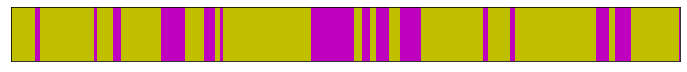

In [308]:
seq=[]
fig_seq,ax_seq=plt.subplots(1,1, figsize=(12,1))
for line in open('../sim_codes/input_files/chr_seq_AB.txt'):
    # print(line)
    val=line.split()
    if 'A' in val[1]: 
        seq.append(1)
        ax_seq.axvspan(float(val[0]), float(val[0])+1, color='m', ec=None)
    elif 'B' in val[1]: 
        seq.append(0)
        ax_seq.axvspan(float(val[0]), float(val[0])+1, color='y', ec=None)

ax_seq.set_xlim([1,500])
ax_seq.set_xticks([])
ax_seq.set_yticks([])

# fig_seq.savefig('../../plots/Chrm_AB/seq.png', dpi=300)
# ax_seq.fill_between(range(len(seq)),0,seq)
# ax_seq.fill_between(range(len(seq)),0,1-np.array(seq))




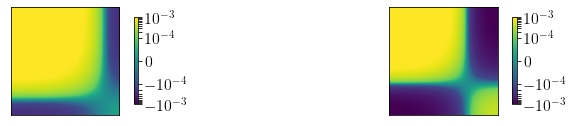

In [374]:
fig,ax=plt.subplots(1,2, figsize=(12,2), gridspec_kw={'wspace':0.3, 'hspace':0.1})

for g,hic_map in enumerate(hic):
    MC1 = np.zeros(np.shape(hic_map))
    for i in range(0,np.shape(hic_map)[0]):
        MC1+= np.diagflat(np.diag(hic_map,k=i)/np.nanmean(np.diag(hic_map,k=i)),i)
    MC1=MC1.T+np.triu(MC1,1)
    dC1 = pd.DataFrame(MC1)
    #axs[0].matshow(dC1,norm=mpl.colors.LogNorm(vmin=1e-1, vmax=2),cmap="Reds")
    cmC1 = dC1.corr()
    # plt.matshow(cmC1,cmap="Reds")

    np.fill_diagonal(cmC1.values,0.0)
    eig_vals, eig_vecs = np.linalg.eig(cmC1)
    eig_vecs[:,0]=eig_vecs[:,0]*np.sign(eig_vecs[0,0])
    # ax[g].plot(eig_vecs[:,0],'k', lw=2)

    sort_eig_vecs=list(eig_vecs[:,0])
    sort_eig_vecs.sort(key = lambda s: float(s),reverse=True)
    # plt.plot(sort_eig_vecs)

    saddle=np.outer(sort_eig_vecs, sort_eig_vecs)
    snmin=saddle.min()
    snmax=saddle.max()
    saddle_smooth = gaussian_filter(saddle, sigma=130)
    c=ax[g].imshow(saddle_smooth, cmap='viridis',norm=SymLogNorm(vmin=-1e-3,vmax=1e-3, linthresh=1e-4))
    plt.colorbar(c, ax=ax[g], shrink=0.8)
    ax[g].set_xticks([])
    ax[g].set_yticks([])
    ax[g].set_xlim([0,500])

    
# fig.savefig('../../plots/Chrm_AB/eig_vecs_compare_active_passive.png', dpi=300)


analyze_traj_SAC_exp_T200.0_F0.0_Ta1.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F1.0_Ta1.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F1.0_Ta100.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F0.1_Ta10.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F5.0_Ta1.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F5.0_Ta100.0_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy
analyze_traj_SAC_exp_T200.0_F5.0_Ta0.1_Esoft4.0_R020.0_G1200_blocksize100_kb10.0_dt0.001_kr30.0_rep1_HiC.npy


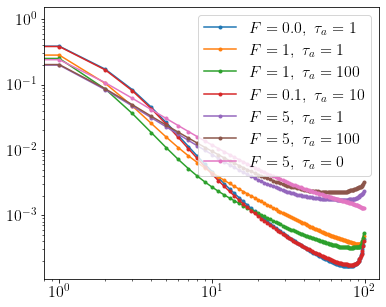

In [7]:
fig,ax=plt.subplots(1,1, figsize=(6,5))

fpath='../../data/SAC_exp/hic/'

for Ta, F in [(1.0,0.0),(1,1),(100,1),(10,0.1),(1,5),(100,5),(0.1,5)]:
    
    for fname in os.listdir(fpath):
        # print(fname)
        if 'Ta{:.1f}'.format(Ta) in fname and 'F{:.1f}'.format(F) in fname:
            print(fname)
            hic=np.load(fpath+fname)
    
            #plot Ps
            dist=[]
            for j in range(1,hic.shape[0]):
                dist.append(np.mean(np.diag(hic,k=j)))
            maxD=np.max(dist)
            dist=np.array(dist)/maxD
            ax.loglog(dist,'.-', label='$F = {},\ \\tau_a = {:.0f}$'.format(F,Ta),)

ax.legend(loc='upper right')

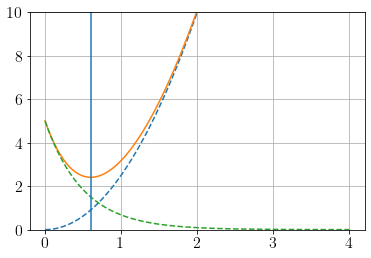

In [36]:
r=np.linspace(0,4,100)
plt.plot(r,0.5*5*r**2,'--')
plt.plot(r,0.5*5*(r)**2+5*np.exp(-2*r))
plt.plot(r,5*np.exp(-2*r),'--')
plt.grid(True)
plt.ylim(0,10)
plt.axvline(0.6)

In [37]:
import numpy as np
T=120
np.arange(int(T),int(T)+300,100)

array([120, 220, 320])